## Bilinear Game Hyperpameter Sensitivity

In [176]:
#####import libraries 
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg as LA

In [177]:
######Fuction to generate invertible square matrix with size n
def invertible_matrix(n):
    randmx = np.random.rand(n,n)
    abs_sum_row = np.sum(np.abs(randmx),axis=1)
    np.fill_diagonal(randmx,abs_sum_row)
    randmx = randmx/(np.sum(randmx,axis=1))
    return randmx

######Function to genereate psd matrix with size n
def psd_matrix(n):
    randmx = np.random.normal(0,1, size=(n,n))
    return np.dot(randmx,randmx.T)


#####Function to genreate pd matrix with size n
def pd_matrix(n):    
    randmx = np.random.normal(0,1,size=(n,n))
    randmx = 1/2*(randmx + randmx.T)
    eigs,eigvectors = np.linalg.eig(randmx)
    eigs_p = np.abs(eigs)
    eigs_p = np.diag(eigs_p)
    return np.dot(np.dot(eigvectors,eigs_p),eigvectors.T)

#####Compute Gradients
def grad(x,y):
    dx = np.dot(C,y)
    dy = -np.dot(C,x)
    return dx,dy

#####Compute Gaussian Stochastic Oracles
def gaussian_noise(x,y,mu):
    std = 0.5
    noise = np.random.normal(mu,std,size=(2*n,1))
    dx,dy = grad(x,y)
    dx_noise = dx + noise[0:n]
    dy_noise = dy + noise[n:2*n]
    return dx_noise,dy_noise
#####Compute Scaled Gaussian Stochastic Oracles
def gaussian_noise_scaled(x,y,mu):
    scaling = 1e-2
    dist = np.sum(x**2 + y**2)
    std = scaling*dist
    noise = np.random.normal(mu,std,size=(2*n,1))
    dx,dy = grad(x,y)
    dx_noise = dx + noise[0:n]
    dy_noise = dy + noise[n:2*n]
    return dx_noise, dy_noise 

##three different noise settings
stochastic_oracle_d = lambda x, y: grad(x,y)
stochastic_oracle_affine = lambda x, y: gaussian_noise(x,y,mu)
stochastic_oracle_decaying =lambda x, y: gaussian_noise_scaled(x,y,mu)

In [178]:
#######Initialized parameters
####dimension of the dataset
n = 50
##########normal distribution parameters
mu = 0.0
seed = 0
random.seed(seed)
#####Generate pd matrix
C = pd_matrix(n)
# #####Generate psd matrix
######number of iterations
N=2000

markevery=N/100
########initialize x_0,y_0
x_0= np.random.normal(0,1,size=(n,1))
y_0 = np.random.normal(0,1,size=(n,1))

x_0 = x_0/ np.sqrt(np.sum(x_0**2 + y_0**2))
y_0 = y_0/ np.sqrt(np.sum(x_0**2 + y_0**2))

In [179]:
########AdaEG-Norm alg
def AdaEG_Norm(N,eta,b_bar,x_0,y_0,stochastic_oracle):
    x,y = x_0,y_0
    dist_opt_hist = [np.sum(x**2 + y**2)]###record distance to the optimal solution, 0 in this case
    dist_opt_avg_hist= [np.sum(x**2 + y**2)]
    grad_x,grad_y = grad(x,y) 
    grad_norm = np.sum(grad_x**2 + grad_y**2)
    grad_norm_hist = [grad_norm]
    grad_norm_avg_hist = [grad_norm]
    x_sum = np.array(x_0)
    y_sum = np.array(y_0)
    stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
    b_bar_hist = [b_bar]
    b = b_bar**2 ###compute b to the fourth in the alg
    N_iters = N
    for i in range(N_iters):
        ###update stepsize for extrapolation step 
        stochastic_grad = np.sum(stochastic_grad_x**2 + stochastic_grad_y**2)
        b = b + stochastic_grad
        alpha = eta[0]/np.power(b,1/4)
        ###update middle points
        x_bar = x - alpha*stochastic_grad_x 
        y_bar = y - alpha*stochastic_grad_y
        ###compute stochastic oracle at middle points
        stochastic_grad_x_bar,stochastic_grad_y_bar = stochastic_oracle(x_bar,y_bar)
        ###update stepsize for intrapolation step
        stochastic_grad_bar = np.sum(stochastic_grad_x_bar**2 + stochastic_grad_y_bar**2)
        b_bar = b_bar +stochastic_grad_bar + stochastic_grad
        b_bar_hist.append(b_bar)
        gamma = eta[1]/np.power(b_bar,1/2)
        ###update x,y
        x = x - gamma*stochastic_grad_x_bar
        y = y - gamma*stochastic_grad_y_bar
        #####record x,y
        #####record x,y
        x_sum = x_sum +np.array(x)
        y_sum = y_sum +np.array(y)
        #####record averaged iterates
        x_avg = x_sum / (i+1)
        y_avg= y_sum /(i+1)
        ###update stochastic oracle at x,y
        stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
        ###record grad_norm at updated x,y
        grad_x,grad_y = grad(x,y) 
        grad_norm = np.sum(grad_x**2 + grad_y**2) 
        grad_norm_hist.append(grad_norm)
        ###record grad_norm_avg 
        grad_norm_avg_hist.append(np.sum(grad_norm_hist)/len(grad_norm_hist))
        ###record the distance to the optimal solution
        dist_opt_hist.append(np.sum(x_bar**2 + y_bar**2))
        dist_opt_avg_hist.append(np.sum(x_avg**2 + y_avg**2))
    return grad_norm_avg_hist,dist_opt_avg_hist,dist_opt_hist
###Initialize the paramters
eta = [1,1]
b_bar = 10e-2

In [180]:
######Two time scale_decaying stepsize
def DSEG(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle):
    
    x,y = x_0,y_0
    longer_stepsize = l_step
    shorter_stepsize = s_step
    dist_opt_hist = [np.sum(x**2 + y**2)] ###record distance to the optimal solution, 0 in this case
    grad_x,grad_y = grad(x,y) 
    grad_norm = np.sum(grad_x**2 + grad_y**2)
    grad_norm_hist = [grad_norm]
    grad_norm_avg_hist = [grad_norm]
    dist_opt_avg_hist=[np.sum(x**2 + y**2)]
    x_sum=np.array(x_0)
    y_sum = np.array(y_0)
    stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
    N_iters = N
    for i in range(N_iters):
        ###update stepsize for extrapolation step 
        alpha = longer_stepsize/(np.power(i+denom,0.1))
        ###update middle points
        x_bar = x - alpha*stochastic_grad_x 
        y_bar = y - alpha*stochastic_grad_y
#       ###compute stochastic oracle at middle points
        stochastic_grad_x_bar,stochastic_grad_y_bar = stochastic_oracle(x_bar,y_bar)
#       ###update stepsize for intrapolation step
        gamma = shorter_stepsize/(np.power(i+denom,0.9))
        ###update x,y
        x = x - gamma*stochastic_grad_x_bar
        y = y - gamma*stochastic_grad_y_bar
        ###update stochastic oracle at x,y
        stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
        #####record x,y
        x_sum = x_sum +np.array(x)
        y_sum = y_sum +np.array(y)
        #####record averaged iterates
        x_avg = x_sum / (i+1)
        y_avg= y_sum /(i+1)
        ###record grad_norm at updated x,y
        grad_x,grad_y = grad(x,y) 
        grad_norm = np.sum(grad_x**2 + grad_y**2) 
        grad_norm_hist.append(grad_norm)
#         ###record grad_norm_avg 
        grad_norm_avg_hist.append(np.sum(grad_norm_hist)/len(grad_norm_hist))
        ###record the distance to the optimal solution
        dist_opt_hist.append(np.sum(x**2 + y**2))
        dist_opt_avg_hist.append(np.sum(x_avg**2+y_avg**2))
    return grad_norm_avg_hist,dist_opt_avg_hist,dist_opt_hist

###Initialize the parameters
denom = 19
l_step = 1
s_step = 0.1

In [181]:
######DSEG two time scale stepsize - fixed (EG+)
def DSEG_fixed(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle):
    
    x,y = x_0,y_0
    longer_stepsize = l_step
    shorter_stepsize = s_step
    dist_opt_hist = [np.sum(x**2 + y**2)] ###record distance to the optimal solution, 0 in this case
    grad_x,grad_y = grad(x,y) 
    grad_norm = np.sum(grad_x**2 + grad_y**2)
    grad_norm_hist = [grad_norm]
    grad_norm_avg_hist = [grad_norm]
    dist_opt_avg_hist=[np.sum(x**2 + y**2)]
    x_sum=np.array(x_0)
    y_sum = np.array(y_0)
    stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
    N_iters = N
    for i in range(N_iters):
        ###update stepsize for extrapolation step 
        alpha = longer_stepsize/(np.power(denom,0.1))
        ###update middle points
        x_bar = x - alpha*stochastic_grad_x 
        y_bar = y - alpha*stochastic_grad_y
#       ###compute stochastic oracle at middle points
        stochastic_grad_x_bar,stochastic_grad_y_bar = stochastic_oracle(x_bar,y_bar)
#       ###update stepsize for intrapolation step
        gamma = shorter_stepsize/(np.power(denom,0.9))
        ###update x,y
        x = x - gamma*stochastic_grad_x_bar
        y = y - gamma*stochastic_grad_y_bar
        ###update stochastic oracle at x,y
        stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
        #####record x,y
        x_sum = x_sum +np.array(x)
        y_sum = y_sum +np.array(y)
        #####record averaged iterates
        x_avg = x_sum / (i+1)
        y_avg= y_sum /(i+1)
        ###record grad_norm at updated x,y
        grad_x,grad_y = grad(x,y) 
        grad_norm = np.sum(grad_x**2 + grad_y**2) 
        grad_norm_hist.append(grad_norm)
#         ###record grad_norm_avg 
        grad_norm_avg_hist.append(np.sum(grad_norm_hist)/len(grad_norm_hist))
        ###record the distance to the optimal solution
        dist_opt_hist.append(np.sum(x**2 + y**2))
        dist_opt_avg_hist.append(np.sum(x_avg**2+y_avg**2))
    return grad_norm_avg_hist,dist_opt_avg_hist,dist_opt_hist

###Initialize the paramters
denom = 19
l_step = 1
s_step = 0.1

In [182]:
etas = np.array([1e-3,1e-2,1e-1,1,2,5,25])
bbar = 1e-2

####Run 20 loops and get the mean value
N_loop = 20
dist_opt_avg_hist_affine= dict()
dist_opt_avg_hist_decaying= dict()
for j in range(len(etas)):
    eta = np.array([etas[j], etas[j]])
    affine_inner = dict()
    decaying_inner = dict()
    for i in range(N_loop):
        normavg, affine_inner[i], distopt = AdaEG_Norm(N,eta,b_bar,x_0,y_0,stochastic_oracle_affine)
        normavg, decaying_inner[i], distopt = AdaEG_Norm(N,eta,b_bar,x_0,y_0,stochastic_oracle_decaying)
    pd1 = pd.DataFrame(affine_inner)
    dist_opt_avg_hist_affine[j] = np.sum(pd1,axis = 1)/N_loop
    pd2 = pd.DataFrame(decaying_inner)
    dist_opt_avg_hist_decaying[j] = np.sum(pd2,axis = 1)/N_loop

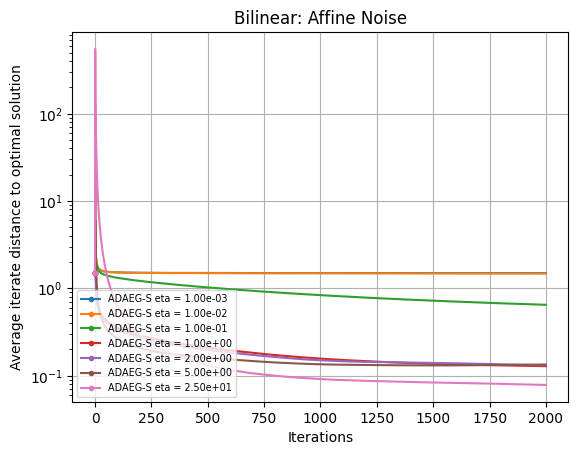

In [183]:
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()

for j in range(len(etas)):
    mylabel = "ADAEG-S eta = %.2e" % etas[j]
    ax1.plot(dist_opt_avg_hist_affine[j],markevery=markevery, marker = '.',label=mylabel)
ax1.set_title("Bilinear: Affine Noise")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Average iterate distance to optimal solution")
ax1.legend(loc=3, fontsize = 'x-small')
#fig1.savefig("bilinear_game_affine_hyperparam_eta")

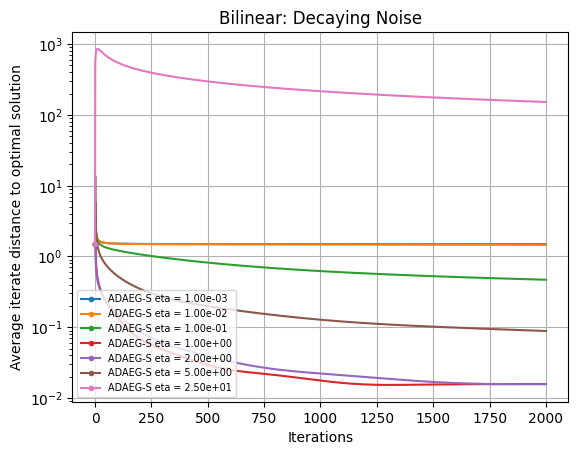

In [184]:
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()

for j in range(len(etas)):
    mylabel = "ADAEG-S eta = %.2e" % etas[j]
    ax1.plot(dist_opt_avg_hist_decaying[j],markevery=markevery, marker = '.',label=mylabel)
ax1.set_title("Bilinear: Decaying Noise")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Average iterate distance to optimal solution")
ax1.legend(loc=3, fontsize = 'x-small')
#fig1.savefig("bilinear_game_decaying_hyperparam_eta")

In [185]:
eta = np.array([1,1])
bbars = np.array([1e-8,1e-6,1e-4,1e-2,1])

####Run 20 loops and get the mean value
N_loop = 20
dist_opt_avg_hist_affine= dict()
dist_opt_avg_hist_decaying= dict()
for j in range(len(bbars)):
    bbar = bbars[j]
    affine_inner = dict()
    decaying_inner = dict()
    for i in range(N_loop):
        normavg, affine_inner[i], distopt = AdaEG_Norm(N,eta,b_bar,x_0,y_0,stochastic_oracle_affine)
        normavg, decaying_inner[i], distopt = AdaEG_Norm(N,eta,b_bar,x_0,y_0,stochastic_oracle_decaying)
    pd1 = pd.DataFrame(affine_inner)
    dist_opt_avg_hist_affine[j] = np.sum(pd1,axis = 1)/N_loop
    pd2 = pd.DataFrame(decaying_inner)
    dist_opt_avg_hist_decaying[j] = np.sum(pd2,axis = 1)/N_loop

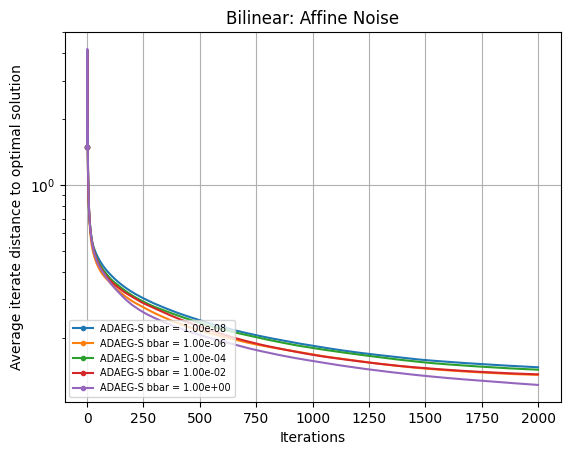

In [186]:
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()

for j in range(len(bbars)):
    mylabel = "ADAEG-S bbar = %.2e" % bbars[j]
    ax1.plot(dist_opt_avg_hist_affine[j],markevery=markevery, marker = '.',label=mylabel)
ax1.set_title("Bilinear: Affine Noise")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Average iterate distance to optimal solution")
ax1.legend(loc=3, fontsize = 'x-small')
#fig1.savefig("bilinear_game_affine_hyperparam_bbar")

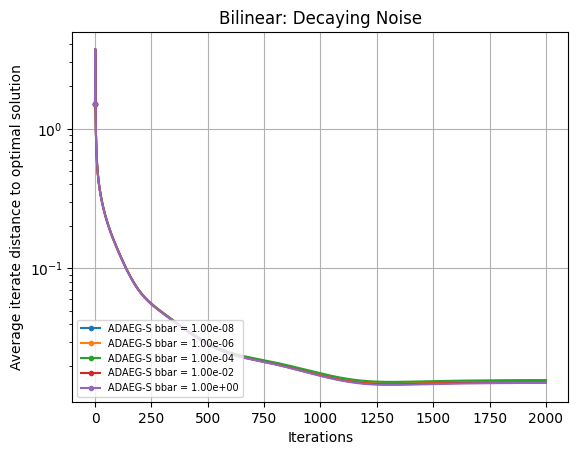

In [187]:
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()

for j in range(len(bbars)):
    mylabel = "ADAEG-S bbar = %.2e" % bbars[j]
    ax1.plot(dist_opt_avg_hist_decaying[j],markevery=markevery, marker = '.',label=mylabel)
ax1.set_title("Bilinear: Decaying Noise")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Average iterate distance to optimal solution")
ax1.legend(loc=3, fontsize = 'x-small')
#fig1.savefig("bilinear_game_decaying_hyperparam_bbar")

In [188]:
denom = 19
l_steps = np.array([1e-3,1e-2,1e-1,1,2])

####Run 20 loops and get the mean value
N_loop = 20
dist_opt_avg_hist_affine= dict()
dist_opt_avg_hist_decaying= dict()
for j in range(len(l_steps)):
    l_step = l_steps[j]
    s_step = (1e-1)*l_step
    affine_inner = dict()
    decaying_inner = dict()
    for i in range(N_loop):
        normavg, affine_inner[i], distopt = DSEG(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_affine)
        normavg, decaying_inner[i], distopt = DSEG(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_decaying)
    pd1 = pd.DataFrame(affine_inner)
    dist_opt_avg_hist_affine[j] = np.sum(pd1,axis = 1)/N_loop
    pd2 = pd.DataFrame(decaying_inner)
    dist_opt_avg_hist_decaying[j] = np.sum(pd2,axis = 1)/N_loop

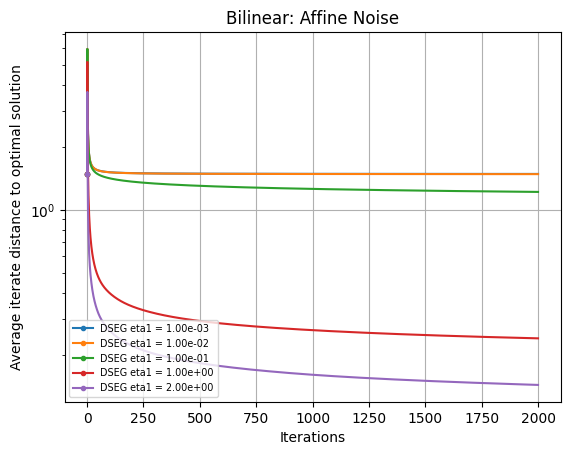

In [189]:
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()

for j in range(len(l_steps)):
    mylabel = "DSEG eta1 = %.2e" % l_steps[j]
    ax1.plot(dist_opt_avg_hist_affine[j],markevery=markevery, marker = '.',label=mylabel)
ax1.set_title("Bilinear: Affine Noise")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Average iterate distance to optimal solution")
ax1.legend(loc=3, fontsize = 'x-small')
#fig1.savefig("bilinear_game_affine_hyperparam_dseg_eta")

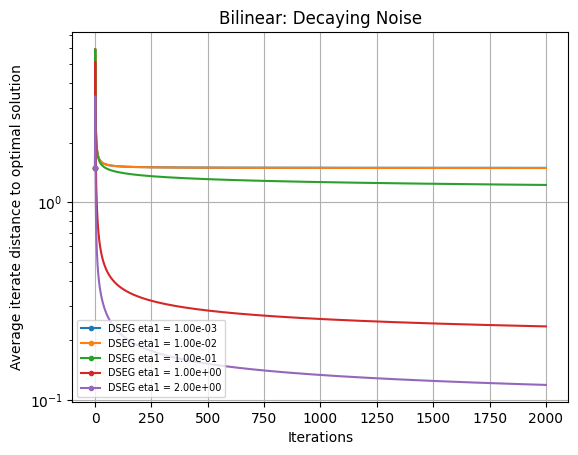

In [190]:
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()

for j in range(len(l_steps)):
    mylabel = "DSEG eta1 = %.2e" % l_steps[j]
    ax1.plot(dist_opt_avg_hist_decaying[j],markevery=markevery, marker = '.',label=mylabel)
ax1.set_title("Bilinear: Decaying Noise")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Average iterate distance to optimal solution")
ax1.legend(loc=3, fontsize = 'x-small')
#fig1.savefig("bilinear_game_decaying_hyperparam_dseg_eta")

In [191]:
denom = 19
l_steps = np.array([1e-3,1e-2,1e-1,1])

####Run 20 loops and get the mean value
N_loop = 20
dist_opt_avg_hist_affine= dict()
dist_opt_avg_hist_decaying= dict()
for j in range(len(l_steps)):
    l_step = l_steps[j]
    s_step = (1e-1)*l_step
    affine_inner = dict()
    decaying_inner = dict()
    for i in range(N_loop):
        normavg, affine_inner[i], distopt = DSEG_fixed(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_affine)
        normavg, decaying_inner[i], distopt = DSEG_fixed(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_decaying)
    pd1 = pd.DataFrame(affine_inner)
    dist_opt_avg_hist_affine[j] = np.sum(pd1,axis = 1)/N_loop
    pd2 = pd.DataFrame(decaying_inner)
    dist_opt_avg_hist_decaying[j] = np.sum(pd2,axis = 1)/N_loop

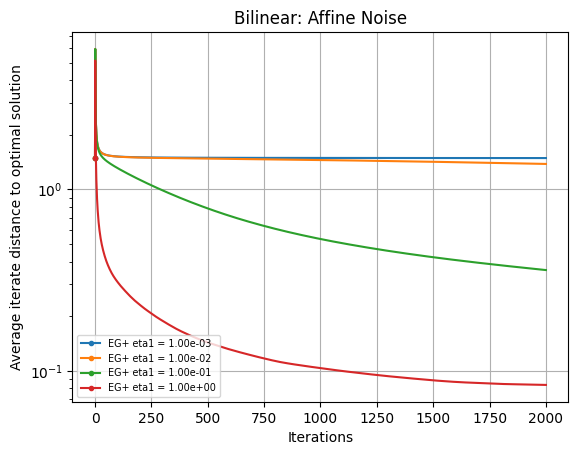

In [192]:
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()

for j in range(len(l_steps)):
    mylabel = "EG+ eta1 = %.2e" % l_steps[j]
    ax1.plot(dist_opt_avg_hist_affine[j],markevery=markevery, marker = '.',label=mylabel)
ax1.set_title("Bilinear: Affine Noise")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Average iterate distance to optimal solution")
ax1.legend(loc=3, fontsize = 'x-small')
#fig1.savefig("bilinear_game_affine_hyperparam_eg+_eta")

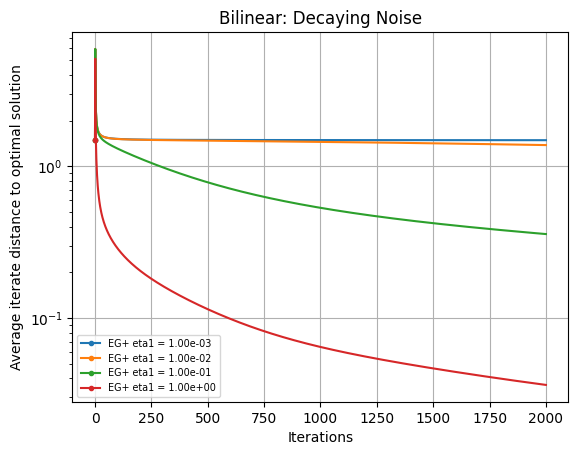

In [193]:
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()

for j in range(len(l_steps)):
    mylabel = "EG+ eta1 = %.2e" % l_steps[j]
    ax1.plot(dist_opt_avg_hist_decaying[j],markevery=markevery, marker = '.',label=mylabel)
ax1.set_title("Bilinear: Decaying Noise")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Average iterate distance to optimal solution")
ax1.legend(loc=3, fontsize = 'x-small')
#fig1.savefig("bilinear_game_decaying_hyperparam_eg+_eta")

In [194]:
etas = np.array([1,2,5])
bbar = 1e-2
l_step_dseg = np.array([1,2])
l_step_dseg_fixed = 1
denom = 19

####Run 20 loops and get the mean value
N_loop = 20
dist_opt_avg_hist_affine_ada= dict()
dist_opt_avg_hist_decaying_ada= dict()
for j in range(len(etas)):
    eta = np.array([etas[j], etas[j]])
    affine_inner = dict()
    decaying_inner = dict()
    for i in range(N_loop):
        normavg, affine_inner[i], distopt = AdaEG_Norm(N,eta,b_bar,x_0,y_0,stochastic_oracle_affine)
        normavg, decaying_inner[i], distopt = AdaEG_Norm(N,eta,b_bar,x_0,y_0,stochastic_oracle_decaying)
    pd1 = pd.DataFrame(affine_inner)
    dist_opt_avg_hist_affine_ada[j] = np.sum(pd1,axis = 1)/N_loop
    pd2 = pd.DataFrame(decaying_inner)
    dist_opt_avg_hist_decaying_ada[j] = np.sum(pd2,axis = 1)/N_loop

dist_opt_avg_hist_affine_dseg= dict()
dist_opt_avg_hist_decaying_dseg= dict()
for j in range(len(l_step_dseg)):
    l_step = l_step_dseg[j]
    s_step = (1e-1)*l_step
    affine_inner = dict()
    decaying_inner = dict()
    for i in range(N_loop):
        normavg, affine_inner[i], distopt = DSEG(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_affine)
        normavg, decaying_inner[i], distopt = DSEG(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_decaying)
    pd1 = pd.DataFrame(affine_inner)
    dist_opt_avg_hist_affine_dseg[j] = np.sum(pd1,axis = 1)/N_loop
    pd2 = pd.DataFrame(decaying_inner)
    dist_opt_avg_hist_decaying_dseg[j] = np.sum(pd2,axis = 1)/N_loop

dist_opt_avg_hist_affine_fixed= dict()
dist_opt_avg_hist_decaying_fixed= dict()
l_step = l_step_dseg_fixed
s_step = (1e-1)*l_step
affine_inner = dict()
decaying_inner = dict()
for i in range(N_loop):
    normavg, affine_inner[i], distopt = DSEG_fixed(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_affine)
    normavg, decaying_inner[i], distopt = DSEG_fixed(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_decaying)
pd1 = pd.DataFrame(affine_inner)
dist_opt_avg_hist_affine_fixed = np.sum(pd1,axis = 1)/N_loop
pd2 = pd.DataFrame(decaying_inner)
dist_opt_avg_hist_decaying_fixed = np.sum(pd2,axis = 1)/N_loop

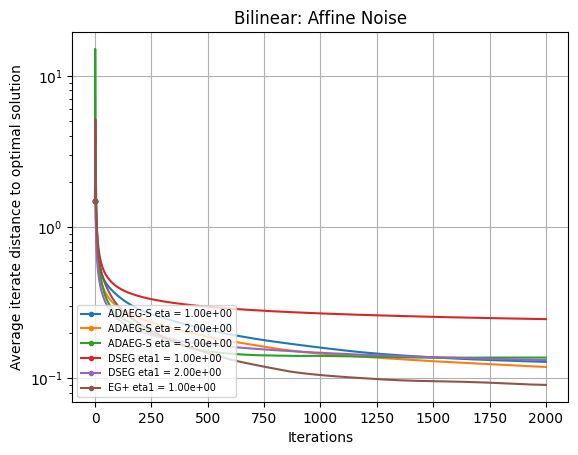

In [ ]:
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()

for j in range(len(etas)):
    mylabel = "ADAEG-S eta = %.2e" % etas[j]
    ax1.plot(dist_opt_avg_hist_affine_ada[j],markevery=markevery, marker = '.',label=mylabel)
for j in range(len(l_step_dseg)):
    mylabel = "DSEG eta1 = %.2e" % l_step_dseg[j]
    ax1.plot(dist_opt_avg_hist_affine_dseg[j],markevery=markevery, marker = '.',label=mylabel)

mylabel = "EG+ eta1 = %.2e" % l_step_dseg_fixed
ax1.plot(dist_opt_avg_hist_affine_fixed,markevery=markevery, marker = '.',label=mylabel)

ax1.set_title("Bilinear: Affine Noise")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Average iterate distance to optimal solution")
ax1.legend(loc=3, fontsize = 'x-small')
#fig1.savefig("bilinear_game_affine_hyperparam_combined")

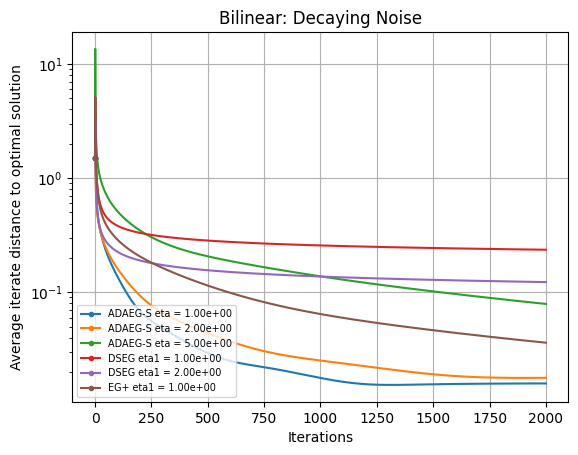

In [ ]:
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()

for j in range(len(etas)):
    mylabel = "ADAEG-S eta = %.2e" % etas[j]
    ax1.plot(dist_opt_avg_hist_decaying_ada[j],markevery=markevery, marker = '.',label=mylabel)
for j in range(len(l_step_dseg)):
    mylabel = "DSEG eta1 = %.2e" % l_step_dseg[j]
    ax1.plot(dist_opt_avg_hist_decaying_dseg[j],markevery=markevery, marker = '.',label=mylabel)

mylabel = "EG+ eta1 = %.2e" % l_step_dseg_fixed
ax1.plot(dist_opt_avg_hist_decaying_fixed,markevery=markevery, marker = '.',label=mylabel)

ax1.set_title("Bilinear: Decaying Noise")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Average iterate distance to optimal solution")
ax1.legend(loc=3, fontsize = 'x-small')
#fig1.savefig("bilinear_game_decaying_hyperparam_combined")